In [34]:
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


# For explicitly displaying widgets
from IPython.display import display

# Just need these for the demo purposes here
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, widgets


In [35]:
import warnings
warnings.filterwarnings('ignore')

- https://github.com/kapilkd13/Ab_testing/blob/main/Ab_testing_simulation.ipynb
- https://www.youtube.com/watch?v=oZ0rTbByECo


## HELPER FUNCTIONS


\\(N= \frac{(Z_{1-\alpha/2}*\sqrt{{2}*\sigma^2_{control}}  +Z_{1-\beta}*\sqrt{\sigma^2_{control} + \sigma^2_{treatment}})^2 }{\delta^2} \\)


In [36]:
from scipy.stats import norm
import numpy as np

class BinomialSatherwaiteSampleSize:
    def __init__(self,baseline_conversion, delta, alpha=0.05, beta=0.2, tailed="two_tailed"):
        self.baseline_conversion=baseline_conversion
        self.delta=delta
        self.alpha=alpha
        self.beta=beta
        self.treatment_conversion=self.baseline_conversion+self.delta
        self.tailed=tailed
#         print(self.baseline_conversion, self.delta, self.beta )
    def get_sample_size(self):
        control_variance=self.baseline_conversion*(1-self.baseline_conversion)
        treatment_variance=self.treatment_conversion*(1-self.treatment_conversion)

        if self.tailed=="two_tailed":
            control_zscore=norm.ppf(1-self.alpha/2)
        elif self.tailed=="one_tailed":
            control_zscore=norm.ppf(1-self.alpha)
        else:
            raise Exception("Wrong input for tailed, select one of [one_tailed,two_tailed]")

        treatment_zscore=norm.ppf(1-self.beta)
        sample_size=int(np.rint(np.power((control_zscore*np.sqrt(2*control_variance) + treatment_zscore*np.sqrt(control_variance + treatment_variance)), 2)/np.power(self.delta,2)))
        return sample_size
  
  
class BinomialPooledSampleSize:
    def __init__(self,baseline_conversion, delta, alpha=0.05, beta=0.2, tailed="two_tailed"):
        self.baseline_conversion=baseline_conversion
        self.delta=delta
        self.alpha=alpha
        self.beta=beta
        self.treatment_conversion=self.baseline_conversion+self.delta
        self.tailed=tailed
    def get_sample_size(self):
        pooled_conversion=(self.baseline_conversion+ self.treatment_conversion)/2
        pooled_variance=pooled_conversion*(1-pooled_conversion)

        if self.tailed=="two_tailed":
            control_zscore=norm.ppf(1-self.alpha/2)
        elif self.tailed=="one_tailed":
            control_zscore=norm.ppf(1-self.alpha)
        else:
            raise Exception("Wrong input for tailed, select one of [one_tailed,two_tailed]")
        treatment_zscore=norm.ppf(1-self.beta)
        sample_size=int(np.rint(2*pooled_variance*np.power((control_zscore + treatment_zscore), 2)/np.power(self.delta,2)))
        return sample_size

class ContinuousSampleSize:
    def __init__(self,baseline_mean, baseline_std, delta, alpha=0.05, beta=0.2, tailed="two_tailed"):
        self.baseline_mean=baseline_mean
        self.baseline_std=baseline_std
        self.delta=delta
        self.alpha=alpha
        self.beta=beta
        self.treatment_mean=self.baseline_mean+self.delta
        self.tailed=tailed
    
    def get_sample_size(self):
        treatment_mean=self.baseline_mean+ self.delta
        if self.tailed=="two_tailed":
            control_zscore=norm.ppf(1-self.alpha/2)
        elif self.tailed=="one_tailed":
            control_zscore=norm.ppf(1-self.alpha)
        else:
            raise Exception("Wrong input for tailed, select one of [one_tailed,two_tailed]")
        treatment_zscore=norm.ppf(1-self.beta)

        sample_size=int(np.rint(2*self.baseline_std*self.baseline_std*np.power((control_zscore + treatment_zscore), 2)/np.power(self.delta,2)))
        return sample_size


In [37]:
class PostExperimentAnalysisContinuous:
    def __init__(self,alpha, N_control, N_treatment, mean_control, mean_treatment, var_control, var_treatment, tailed="two_tailed"):
        self.alpha=alpha
        self.N_control=N_control
        self.N_treatment=N_treatment
        self.mean_control=mean_control
        self.mean_treatment=mean_treatment
        self.var_control=var_control
        self.var_treatment=var_treatment
        self.tailed=tailed
    
    def analyze_data(self):
        
        print(np.sqrt(self.var_control/self.N_control + self.var_treatment/self.N_treatment))
        # Pooled Variance
        se_pooled = np.sqrt(self.var_control/self.N_control + self.var_treatment/self.N_treatment)

        # Test statistics
        test_statistic = (self.mean_treatment-self.mean_control)/se_pooled
        
        if self.tailed=="two_tailed":
            p_value = norm.sf(test_statistic)*2
            z_critical  = norm.ppf(1-self.alpha/2)
        elif self.tailed=="one_tailed":
            p_value = norm.sf(test_statistic)
            z_critical  = norm.ppf(1-self.alpha)
            
        else:
            raise Exception("Wrong input for tailed, select one of [one_tailed,two_tailed]")
        

        m = z_critical*se_pooled

        # Confidence Interval
        delta=( self.mean_treatment- self.mean_control)
        CI = [delta - m, delta + m]

        return {"p_value":p_value, "test_statistic":test_statistic, "delta":delta ,"CI_lower_bound":CI[0],"CI_upper_bound":CI[1]}



In [38]:


class PostExperimentAnalysisProportion:
    def __init__(self,alpha, N_control, N_treatment, N_control_pos, N_treatment_pos, tailed="two_tailed"):
        self.alpha=alpha
        self.N_control=N_control
        self.N_treatment=N_treatment
        self.N_control_pos=N_control_pos
        self.N_treatment_pos=N_treatment_pos
        self.tailed=tailed
    
    def analyze_data(self):
        
        mean_control= self.N_control_pos/self.N_control
        mean_treatment= self.N_treatment_pos/self.N_treatment
        mean_pooled=(self.N_control_pos+self.N_treatment_pos)/(self.N_control+ self.N_treatment)
        var_pooled=mean_pooled*(1-mean_pooled)*(1/self.N_control +1/self.N_treatment)
        
        # Pooled SE
        se_pooled = np.sqrt(var_pooled)

        # Test statistics
        test_statistic = (mean_treatment-mean_control)/se_pooled
        
        if self.tailed=="two_tailed":
            p_value = norm.sf(test_statistic)*2
            z_critical  = norm.ppf(1-self.alpha/2)
        elif self.tailed=="one_tailed":
            p_value = norm.sf(test_statistic)
            z_critical  = norm.ppf(1-self.alpha)
            
        else:
            raise Exception("Wrong input for tailed, select one of [one_tailed,two_tailed]")
        

        m = z_critical*se_pooled

        # Confidence Interval
        delta=(mean_treatment- mean_control)
        CI = [delta - m, delta + m]

        return {"p_value":p_value, "test_statistic":test_statistic, "delta":delta ,"CI_lower_bound":CI[0],"CI_upper_bound":CI[1]}



In [39]:
alpha=0.05
tailed="two_tailed"
N_control=500
N_treatment= 500
data_control= np.random.normal(loc=50, scale=5,  size = N_control)
data_treatment= np.random.normal(loc=50, scale=5,  size = N_treatment)

mean_control=np.mean(data_control)
var_control=np.var(data_control)


mean_treatment=np.mean(data_treatment)
var_treatment=np.var(data_treatment)

post_analysis_continuous=PostExperimentAnalysisContinuous(alpha, N_control, N_treatment, mean_control, 
                        mean_treatment, var_control, var_treatment, tailed=tailed)
post_analysis_continuous.analyze_data()

0.31804297340774135


{'p_value': 0.5770497014699533,
 'test_statistic': 0.5576993502182948,
 'delta': 0.17737235961099174,
 'CI_lower_bound': -0.4459804138042115,
 'CI_upper_bound': 0.800725133026195}

In [40]:
alpha=0.05
tailed="two_tailed"
N_control=1000
N_control_pos= 800
N_treatment= 1250
N_treatment_pos= 1200


mean_control=N_control_pos/N_control
mean_treatment=N_treatment_pos/N_treatment



post_analysis_proportion= PostExperimentAnalysisProportion(alpha, N_control, N_treatment, N_control_pos, N_treatment_pos, tailed="two_tailed")
post_analysis_proportion.analyze_data()

{'p_value': 3.552964224155714e-33,
 'test_statistic': 11.999999999999991,
 'delta': 0.15999999999999992,
 'CI_lower_bound': 0.1338671468727992,
 'CI_upper_bound': 0.18613285312720065}

#### Cuped simulation

In [41]:
# Continuous Example

import numpy as np
import pandas as pd

class SimulateCupedContinuous:
    
    def __init__(self, N_users, split_ratio, control_mean, control_std, treatment_lift, random_effect_std):
        self.N_users=N_users
        self.split_ratio=split_ratio
        self.control_mean=control_mean
        self.control_std=control_std
        self.treatment_lift=treatment_lift
        self.random_effect_std=random_effect_std
        
    def get_cuped_adjusted(self,T_before, T_after, C_before, C_after):
  
        covariance = np.cov([T_after + C_after, C_before + T_before])
        theta = covariance[0, 1] / covariance[1, 1]
        mean_before = np.mean(T_before + C_before)
        T_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(T_after, T_before)]
        C_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(C_after, C_before)]
        return T_after_adjusted, C_after_adjusted
    
    def analyze_data(self):
        
        
        treatment_user_count=int(self.N_users*self.split_ratio)
        control_user_count=total_users- treatment_user_count


        user_ids=range(total_users)
        pre_experiment_data=np.random.normal(self.control_mean, self.control_std, self.N_users)
        performance_df= pd.DataFrame({"user_id":user_ids, "pre_experiment_data":pre_experiment_data})

        # randomly assign x percent people to treatment
        treatment_users=np.random.choice(user_ids, treatment_user_count, replace=False)

        performance_df["treatment"]=performance_df["user_id"].apply(lambda x: 1 if x in treatment_users else 0)
        performance_df["post_experiment_data"]=performance_df[["pre_experiment_data","treatment"]].apply(lambda x: x[0]
                                                +np.random.normal(0, self.random_effect_std)+ self.treatment_lift if x[1]==1 else x[0]+np.random.normal(0, self.random_effect_std), axis=1)
        
        T_before=list(performance_df[performance_df["treatment"]==1]["pre_experiment_data"])
        T_after=list(performance_df[performance_df["treatment"]==1]["post_experiment_data"])
        C_before=list(performance_df[performance_df["treatment"]==0]["pre_experiment_data"])
        C_after=list(performance_df[performance_df["treatment"]==0]["post_experiment_data"])
#         print(np.cov([T_after + C_after, C_before + T_before]))
        T_after_adjusted, C_after_adjusted= self.get_cuped_adjusted(T_before, T_after, C_before, C_after)
        
        print("pre experiment metrics")
        y_treat=performance_df[performance_df["treatment"]==1]["pre_experiment_data"]
        print(f"treatment metrics: mean: {np.mean(y_treat)}, var: {np.var(y_treat)}")

        y_control=performance_df[performance_df["treatment"]==0]["pre_experiment_data"]
        print(f"control metrics: mean: {np.mean(y_control)}, var: {np.var(y_control)}")


        print("post experiment metrics")
        y_treat=performance_df[performance_df["treatment"]==1]["post_experiment_data"]
        print(f"treatment metrics: mean: {np.mean(y_treat)}, var: {np.var(y_treat)}")

        y_control=performance_df[performance_df["treatment"]==0]["post_experiment_data"]
        print(f"control metrics: mean: {np.mean(y_control)}, var: {np.var(y_control)}")
        
        print("post experiment metrics: After CUPED Application")
        print(f"treatment metrics: mean: {np.mean(T_after_adjusted)}, var: {np.var(T_after_adjusted)}")
        print(f"control metrics: mean: {np.mean(C_after_adjusted)}, var: {np.var(C_after_adjusted)}")
        
    
total_users=1000
treatment_ratio=0.5
treatment_user_count=int(total_users*treatment_ratio)
control_user_count=total_users- treatment_user_count

random_effect_std=5
prior_mean=50
prior_std=10
treatment_lift=2

user_ids=range(total_users)
pre_experiment_data=np.random.normal(prior_mean, prior_std, total_users)
performance_df= pd.DataFrame({"user_id":user_ids, "pre_experiment_data":pre_experiment_data})

# randomly assign 50 percent people to treatment
treatment_users=np.random.choice(user_ids, treatment_user_count, replace=False)

performance_df["treatment"]=performance_df["user_id"].apply(lambda x: 1 if x in treatment_users else 0)

# treatment_user_df= pd.DataFrame({"user_id":user_ids, "pre_experiment_data":pre_experiment_data})

performance_df["post_experiment_data"]=performance_df[["pre_experiment_data","treatment"]].apply(lambda x: x[0]+np.random.normal(0, random_effect_std)+ treatment_lift if x[1]==1 else x[0]+np.random.normal(0, random_effect_std), axis=1)


In [42]:
total_users=1000
treatment_ratio=0.5
control_mean=50
control_std=10
treatment_lift=5
random_effect_std= 5
sim_cuped=SimulateCupedContinuous(total_users, treatment_ratio,control_mean, control_std, treatment_lift, random_effect_std)

sim_cuped.analyze_data()

pre experiment metrics
treatment metrics: mean: 50.142103441673015, var: 98.97653551485864
control metrics: mean: 50.05086292070983, var: 94.86915083122362
post experiment metrics
treatment metrics: mean: 55.23545526671837, var: 124.74295909709186
control metrics: mean: 50.02519443024743, var: 118.34701163482147
post experiment metrics: After CUPED Application
treatment metrics: mean: 55.235174332415845, var: 123.55438139513056
control metrics: mean: 50.02547536454996, var: 117.20995849791889


In [43]:
## Concepts

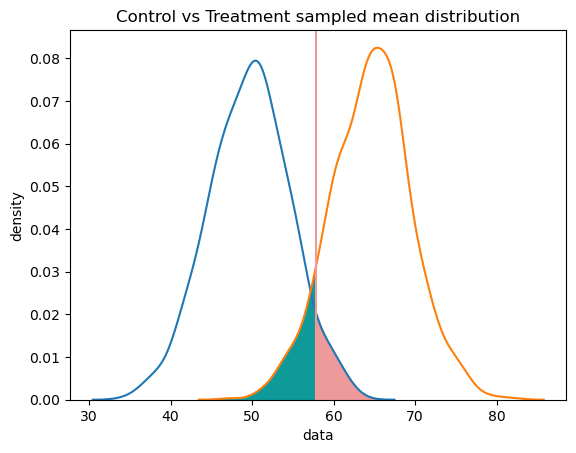

interactive(children=(FloatSlider(value=0.05, description='Significance level', max=1.0, min=0.01, step=0.01, …

In [44]:
alpha = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='Significance level',style= {'description_width': 'initial'})

control_mean = widgets.IntSlider(min=1, max=100, step=1, value=50, description='control_mean')
treatment_mean = widgets.IntSlider(min=1, max=100, step=1, value=65, description='treatment_mean', style= {'description_width': 'initial'})

control_std = widgets.IntSlider(min=1, max=100, step=1, value=5, description='control_std', style= {'description_width': 'initial'})
treatment_std = widgets.IntSlider(min=1, max=100, step=1, value=5,  description='treatment_std', style= {'description_width': 'initial'})

control_sample_size = widgets.IntSlider(min=50, max=100000, step=50, value=1000,  description='control_sample_size', style= {'description_width': 'initial'})
treatment_sample_size = widgets.IntSlider(min=50, max=100000, step=50, value=1000,  description='treatment_sample_size', style= {'description_width': 'initial'})

# Specifying the handler for the n argument in the function
@interact(alpha=alpha,control_mean = control_mean, treatment_mean = treatment_mean, control_std=control_std,
          treatment_std=treatment_std, control_sample_size=control_sample_size, 
          treatment_sample_size=treatment_sample_size )
def plot_random_scatterplot(alpha, control_mean, treatment_mean,control_std, treatment_std, control_sample_size, treatment_sample_size):
  
   
    control_data = np.random.normal(loc=control_mean, scale=control_std, size=control_sample_size)
    treatment_data = np.random.normal(loc=treatment_mean, scale=treatment_std, size=treatment_sample_size)
#     bins = int(np.sqrt(len(control_data)))
    ax1=sns.distplot(control_data , hist=False )
    ax2=sns.distplot(treatment_data, hist=False)
    kde_x1, kde_y1 = ax1.lines[0].get_data()
    kde_x2, kde_y2 = ax2.lines[1].get_data()
#     print(kde_y1,kde_y2)
    #plotting the two lines
    
#     poi1,poi2=find_intersection_points(ax1, ax2,control_mean)

    poi1= np.mean(control_data)+norm.ppf(1-alpha)*np.std(control_data)
#     print(poi1,poi2)
#     x0=40
#     

    if poi1!=None:
        p1 = plt.axvline(x=poi1,color='#EF9A9A')
#         p2 = plt.axvline(x=poi2,color='#EF9A9A')
        
        ax1.fill_between(kde_x1, kde_y1, where=(kde_x1>poi1) , 
                        interpolate=True, color='#EF9A9A')
        
        ax2.fill_between(kde_x2, kde_y2, where=((kde_x2<poi1)) , 
                        interpolate=True, color='#0F9A9A')

    plt.title('Control vs Treatment sampled mean distribution')
    plt.xlabel('data')
    plt.ylabel('density')

#### CLT

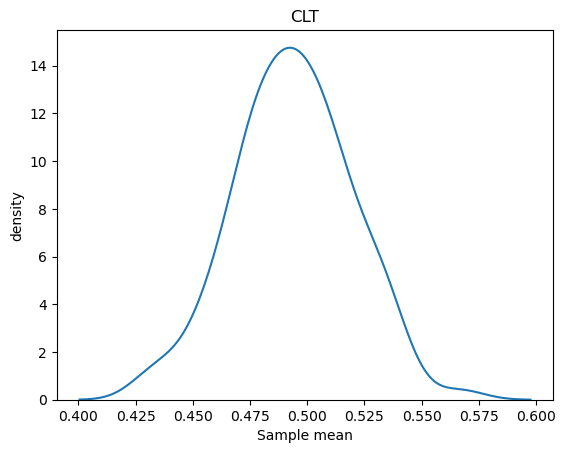

interactive(children=(IntSlider(value=100, description='N_simulation', max=1000, min=1, step=5, style=SliderSt…

In [21]:


N_simulation = widgets.IntSlider(min=1, max=1000, step=5, value=100, description='N_simulation',style= {'description_width': 'initial'})
sample_size = widgets.IntSlider(min=1, max=1000, step=5, value=100, description='sample_size',style= {'description_width': 'initial'})

low = widgets.IntSlider(min=0, max=100, step=1, value=0, description='low',style= {'description_width': 'initial'})
high = widgets.IntSlider(min=1, max=100, step=1, value=1, description='high',style= {'description_width': 'initial'})


# Specifying the handler for the argument in the function
@interact(N_simulation=N_simulation,sample_size=sample_size, low=low, high=high )
def CLT_simulation(N_simulation, sample_size, low, high):
    
    
    mean_list=[]
    for x in range(N_simulation):
        data=np.random.uniform(low=low,high=high,size=sample_size)
        mean_list.append(np.mean(data))
        
    ax1=sns.distplot(mean_list , hist=False )
    plt.title('CLT')
    plt.xlabel('Sample mean')
    plt.ylabel('density')

### Delta distribution

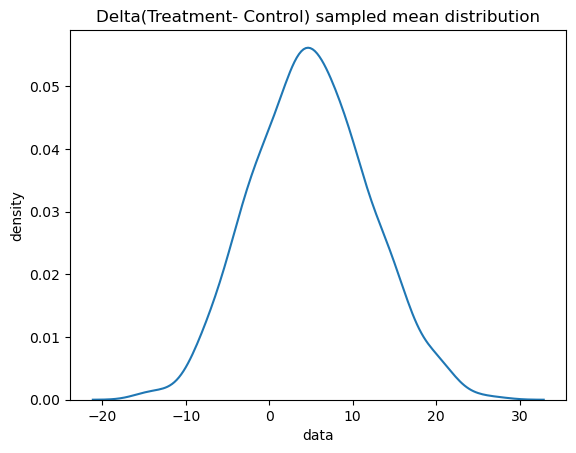

interactive(children=(IntSlider(value=50, description='control_mean', min=1), IntSlider(value=55, description=…

In [46]:
control_mean = widgets.IntSlider(min=1, max=100, step=1, value=50, description='control_mean')
treatment_mean = widgets.IntSlider(min=1, max=100, step=1, value=55, description='treatment_mean', style= {'description_width': 'initial'})

control_std = widgets.IntSlider(min=1, max=100, step=1, value=5, description='control_std', style= {'description_width': 'initial'})
treatment_std = widgets.IntSlider(min=1, max=100, step=1, value=5,  description='treatment_std', style= {'description_width': 'initial'})

sample_size = widgets.IntSlider(min=50, max=100000, step=50, value=1000,  description='sample_size', style= {'description_width': 'initial'})
# treatment_sample_size = widgets.IntSlider(min=50, max=100000, step=50, value=1000,  description='treatment_sample_size', style= {'description_width': 'initial'})

# Specifying the handler for the argument in the function
@interact(control_mean = control_mean, treatment_mean = treatment_mean, control_std=control_std,
          treatment_std=treatment_std,sample_size=sample_size )
def plot_delta_distribution(control_mean, treatment_mean,control_std, treatment_std, sample_size):
  
   
    control_data = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)
    treatment_data = np.random.normal(loc=treatment_mean, scale=treatment_std, size=sample_size)
    delta_data=np.subtract(treatment_data, control_data)
    
#     bins = int(np.sqrt(len(control_data)))
    ax1=sns.distplot(delta_data , hist=False )
   

    # Adding some labels
    plt.title('Delta(Treatment- Control) sampled mean distribution')
    plt.xlabel('data')
    plt.ylabel('density')
    


### Sample size calculator: Proportion metric

In [14]:
alpha = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='alpha',style= {'description_width': 'initial'})
beta = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.2, description='beta',style= {'description_width': 'initial'})
baseline_conversion = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.3, description='baseline_conversion',style= {'description_width': 'initial'})
delta = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.02, description='absolute delta', style= {'description_width': 'initial'})

tail_dropdown = widgets.Dropdown(
    options= ["one_tailed", "two_tailed"],
    index=1,           
    disabled=False,        
    description='experiment_type'  ,style= {'description_width': 'initial'}
)


# Specifying the handler for the argument in the function
@interact(alpha = alpha, beta = beta, baseline_conversion=baseline_conversion,
          delta=delta, tail_dropdown=tail_dropdown )
def proportion_sample_size_calculator(alpha, beta , baseline_conversion,
          delta, tail_dropdown):
  
    ss_calculator=BinomialSatherwaiteSampleSize(baseline_conversion, delta, alpha=alpha, beta=beta, tailed=tail_dropdown)
    sample_size=ss_calculator.get_sample_size()
    print(f'''At alpha:{alpha}, beta: {beta}, baseline_conversion: {baseline_conversion}, absolute_delta:{delta}
          You will need {sample_size} samples per variation''')
    

At alpha:0.05, beta: 0.2, baseline_conversion: 0.3, absolute_delta:0.02
          You will need 8286 samples per variation


interactive(children=(FloatSlider(value=0.05, description='alpha', max=1.0, min=0.01, step=0.01, style=SliderS…

### Sample size calculator: Continuous metric

In [15]:
alpha = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='alpha',style= {'description_width': 'initial'})
beta = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.2, description='beta',style= {'description_width': 'initial'})
baseline_mean = widgets.IntSlider(min=1, max=100, step=1, value=50, description='baseline_mean',style= {'description_width': 'initial'})
baseline_std = widgets.IntSlider(min=1, max=1000, step=1, value=5, description='baseline_std',style= {'description_width': 'initial'})
delta = widgets.FloatSlider(min=1, max=100, step=1, value=5, description='absolute delta', style= {'description_width': 'initial'})

tail_dropdown = widgets.Dropdown(
    options= ["one_tailed", "two_tailed"],
    index=1,           
    disabled=False,        
    description='hypothesis_type'  ,style= {'description_width': 'initial'}
)


# Specifying the handler for the argument in the function
@interact(alpha = alpha, beta = beta, baseline_mean=baseline_mean, baseline_std=baseline_std,
          delta=delta, tail_dropdown=tail_dropdown )
def proportion_sample_size_calculator(alpha, beta , baseline_mean,baseline_std,
          delta, tail_dropdown):
  
    ss_calculator=ContinuousSampleSize(baseline_mean, baseline_std, delta, alpha=alpha, beta=beta, tailed=tail_dropdown)
    sample_size=ss_calculator.get_sample_size()
    print(f'''At alpha:{alpha}, beta: {beta}, baseline_mean: {baseline_mean}, baseline_std: {baseline_std} , absolute_delta:{delta}, hypothesis_type:{tail_dropdown}
          You will need {sample_size} samples per variation''')
    

At alpha:0.05, beta: 0.2, baseline_mean: 50, baseline_std: 5 , absolute_delta:5.0, hypothesis_type:two_tailed
          You will need 16 samples per variation


interactive(children=(FloatSlider(value=0.05, description='alpha', max=1.0, min=0.01, step=0.01, style=SliderS…

### Post Experiment Analysis

#### Continuous metric

In [16]:
alpha = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='alpha',style= {'description_width': 'initial'})
N_control = widgets.IntSlider(min=100, max=10000, step=10, value=500, description='Num_samples_control',style= {'description_width': 'initial'})
N_treatment = widgets.IntSlider(min=100, max=10000, step=10, value=500, description='Num_samples_treatment',style= {'description_width': 'initial'})

mean_control = widgets.IntSlider(min=1, max=100, step=1, value=50, description='control_mean',style= {'description_width': 'initial'})
mean_treatment = widgets.IntSlider(min=1, max=100, step=1, value=55, description='treatment_mean',style= {'description_width': 'initial'})

std_control = widgets.IntSlider(min=1, max=100, step=1, value=5, description='control_std',style= {'description_width': 'initial'})
std_treatment = widgets.IntSlider(min=1, max=1000, step=1, value=5, description='treatment_std',style= {'description_width': 'initial'})

tail_dropdown = widgets.Dropdown(
    options= ["one_tailed", "two_tailed"],
    index=1,           
    disabled=False,        
    description='hypothesis_type'  ,style= {'description_width': 'initial'}
)


# Specifying the handler for the argument in the function
@interact(alpha = alpha, N_control=N_control, N_treatment=N_treatment, mean_control=mean_control, mean_treatment=mean_treatment,
          std_control=std_control, std_treatment=std_treatment,  tail_dropdown=tail_dropdown )
def post_experiment_analysis_continuous(alpha, N_control, N_treatment, mean_control, mean_treatment,
          std_control, std_treatment, tail_dropdown):
    
    data_control= np.random.normal(loc=mean_control, scale=std_control,  size = N_control)
    data_treatment= np.random.normal(loc=mean_treatment, scale=std_treatment,  size = N_treatment)
    
    mean_c=np.mean(data_control)
    var_c=np.var(data_control)


    mean_t=np.mean(data_treatment)
    var_t=np.var(data_treatment)
    
#     print(N_control, N_treatment)
#     print(np.sqrt(var_control/N_control + var_treatment/N_treatment))
    post_analysis_continuous=PostExperimentAnalysisContinuous(alpha, N_control, N_treatment, mean_c, 
                        mean_t, var_c, var_t, tailed=tail_dropdown)
    data=post_analysis_continuous.analyze_data()
    print(f''' For above experiment setting: 
    You get
    \t p_value: {data["p_value"]},
    \t test-statistic: {data["test_statistic"]},
    \t delta: {data["delta"]} with CI({(1-alpha)*100}%):[{data["CI_lower_bound"]} <--> {data["CI_upper_bound"]}]''')
    

0.3145433743722212
 For above experiment setting: 
    You get
    	 p_value: 1.9257143998086306e-71,
    	 test-statistic: 17.87266484705857,
    	 delta: 5.6217283100175806 with CI(95.0%):[5.005234624672328 <--> 6.238221995362833]


interactive(children=(FloatSlider(value=0.05, description='alpha', max=1.0, min=0.01, step=0.01, style=SliderS…

#### Proportional metric

In [22]:
alpha = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.05, description='alpha',style= {'description_width': 'initial'})
N_control = widgets.IntSlider(min=100, max=10000, step=10, value=1000, description='Num_samples_control',style= {'description_width': 'initial'})
N_treatment = widgets.IntSlider(min=100, max=10000, step=10, value=1250, description='Num_samples_treatment',style= {'description_width': 'initial'})

N_control_pos = widgets.IntSlider(min=100, max=10000, step=10, value=500, description='Num_samples_control_pos',style= {'description_width': 'initial'})
N_treatment_pos = widgets.IntSlider(min=100, max=10000, step=10, value=800, description='Num_samples_treatment_pos',style= {'description_width': 'initial'})


tail_dropdown = widgets.Dropdown(
    options= ["one_tailed", "two_tailed"],
    index=1,           
    disabled=False,        
    description='hypothesis_type'  ,style= {'description_width': 'initial'}
)


# Specifying the handler for the argument in the function
@interact(alpha = alpha, N_control=N_control, N_treatment=N_treatment, N_control_pos=N_control_pos, N_treatment_pos=N_treatment_pos,
          tail_dropdown=tail_dropdown )
def post_experiment_analysis_continuous(alpha, N_control, N_treatment, N_control_pos, N_treatment_pos, tail_dropdown):
    
    post_analysis_proportion= PostExperimentAnalysisProportion(alpha, N_control, N_treatment, N_control_pos, N_treatment_pos, tailed="two_tailed")
    data=post_analysis_proportion.analyze_data()
    print(f''' For above experiment setting: 
    You get
    \t p_value: {data["p_value"]},
    \t test-statistic: {data["test_statistic"]},
    \t delta: {data["delta"]} with CI({(1-alpha)*100}%):[{data["CI_lower_bound"]} <--> {data["CI_upper_bound"]}]''')
    

 For above experiment setting: 
    You get
    	 p_value: 2.3733340626255564e-11,
    	 test-statistic: 6.680990011245667,
    	 delta: 0.14 with CI(95.0%):[0.09892899744293335 <--> 0.18107100255706668]


interactive(children=(FloatSlider(value=0.05, description='alpha', max=1.0, min=0.01, step=0.01, style=SliderS…

In [18]:
def simulate_experiment_data(baseline_conversion, delta, n_samples):

    control_data= np.random.binomial(1,baseline_conversion, n_samples)
    treatment_data= np.random.binomial(1,baseline_conversion+delta, n_samples)

    simulated_df=pd.DataFrame({"treatment":([0]*len(control_data)+ [1]*len(treatment_data) ), "value":np.concatenate((control_data,treatment_data))})
    return simulated_df

In [19]:

baseline_conversion=0.3
delta=0.02
n_samples=10000

simulated_data=simulate_experiment_data(baseline_conversion=baseline_conversion, delta=delta, n_samples=n_samples)
simulated_data


,treatment,value
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
19995,1,0
19996,1,0
19997,1,1
19998,1,1


In [20]:
alpha=0.05
tail_dropdown="two_tailed"
N_control=n_samples
N_treatment= n_samples

N_control_pos=len(simulated_data[((simulated_data["treatment"]==0) &(simulated_data["value"]==1) )])
N_treatment_pos=len(simulated_data[((simulated_data["treatment"]==1) &(simulated_data["value"]==1) )])

print(N_control_pos,N_treatment_pos)
post_experiment_analysis_continuous(alpha, N_control, N_treatment, N_control_pos, N_treatment_pos, tail_dropdown)

2977 3185
 For above experiment setting: 
    You get
    	 p_value: 0.0014449233375682811,
    	 test-statistic: 3.1855235689241055,
    	 delta: 0.020799999999999985 with CI(95.0%):[0.008002338957359504 <--> 0.03359766104264047]


there p value is lesser than 0.05 hence reject null hypotheses which is basically reject that there is no change in treatment and control (here we forcefuly did it because we synthetically created the data with delta of .02 in treatment)
